## Deloitte Hackathon Code - Payroll Dataset 
#### This document has code which covers 4 identified rules to create risk profiles for the Payroll Dataset. Summary and visualisations are provided in the slides attached. 

In [ ]:
pip install sqlalchemy

In [ ]:
pip install mysql.connector

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math as math
import numpy as np 
import seaborn as sns 
import sqlalchemy as db

import mysql.connector 
from mysql.connector import Error

In [ ]:
def create_db_connection():
    connection = None
    try:
        connection = mysql.connector.connect(
            host="bac.c5spguzjvsqr.ap-southeast-1.rds.amazonaws.com",
            user="admin",
            passwd= "^IW[qN8cs]znCPK2XE",
            database="bac"
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [ ]:
cn = create_db_connection()

MySQL Database connection successful


In [ ]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

In [ ]:
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return pd.DataFrame(result, columns= list(cursor.column_names))
    except Error as err:
        print(f"Error: '{err}'")

In [ ]:
# Importing income dataset
query1 = "SELECT * FROM income_csv GROUP BY employee_master"
read_query(cn, query1)

,Column1,employee_master,date,division,grade,description,amount,payment_type,payment_sub_type,relevant_income,employee_type
0,1,0020020,2021-08-28,IDT,14H,Salary/Wages,10074,Earning,Ordinary,Yes,Monthly Paid
1,25,0020021,2021-09-28,IDT,11H,Salary/Wages,7314,Earning,Ordinary,Yes,Monthly Paid
2,49,0020023,2021-08-28,BDG,17,Salary/Wages,24216,Earning,Ordinary,Yes,Monthly Paid
3,73,0020025,2021-10-28,GSM,14H,Salary/Wages,12456,Earning,Ordinary,Yes,Monthly Paid
4,97,0020050,2021-08-28,FDN-HF,14S,Salary/Wages,13638,Earning,Ordinary,Yes,Monthly Paid
...,...,...,...,...,...,...,...,...,...,...,...
1895,58088,0497117,2021-07-28,E&M,17,Salary/Wages,18120,Earning,Ordinary,Yes,Monthly Paid
1896,58112,0497436,2021-07-28,E&M,12S,Salary/Wages,9420,Earning,Ordinary,Yes,Monthly Paid
1897,58144,0497437,2021-12-28,E&M,12S,Salary/Wages,12000,Earning,Ordinary,Yes,Monthly Paid
1898,58174,0497439,2021-09-28,E&M,17,Salary/Wages,19456,Earning,Ordinary,Yes,Monthly Paid


### Rule 1: Does every employee ID have only one unique bank account?

In [ ]:
## Step 1: Check if all Employee IDs are unique
query_1_1 = "SELECT * FROM nn_employee"
df_payroll_employee =pd.DataFrame(read_query(cn, query_1_1))

print(df_payroll_employee['employee_master'].nunique())
print(df_payroll_employee['bank_acct'].nunique())
## Since there are 2003 records in Employee dataset and 2003 unique employee IDs, all employees are unique.
## But there are only 2001 unique bank accounts. 




2003
2001


In [ ]:
## Step 2: Identify common bank account
df_bankdups = pd.DataFrame(df_payroll_employee[df_payroll_employee["bank_acct"].duplicated(keep=False)].employee_master)

#4 Employee IDs share 2 bank accounts. 
df_bankdups

# # Comparing with Credit Card Data to see if these employees have transacted 
query_1_7 = "SELECT employee_number, net_amount FROM Transaction_Data_csv"
df_transaction_data = read_query(cn, query_1_7)

df_credit_dups = pd.merge(df_bankdups, df_transaction_data, how = "left", left_on = ["employee_master"],right_on= ["employee_number"])
df_credit_dups


,employee_master,employee_number,net_amount
0,0020186,0020186,0
1,0020186,0020186,45.45
2,0020186,0020186,10.91
3,0020186,0020186,8.97
4,0020186,0020186,9.55
...,...,...,...
86,0038776,0038776,120.93
87,020186A,020186A,158.48
88,020186A,020186A,519.55
89,020186A,020186A,1120.41


### Rule 2: Check if the proportion of pension is accurate

In [ ]:
#Extract income_csv from DB 
query_1_5 = "SELECT * FROM income_csv"
df_income = read_query(cn,query_1_5)
df_income

,Column1,employee_master,date,division,grade,description,amount,payment_type,payment_sub_type,relevant_income,employee_type
0,1,0020020,2021-08-28,IDT,14H,Salary/Wages,10074,Earning,Ordinary,Yes,Monthly Paid
1,2,0020020,2021-08-28,IDT,14H,Basic Allowance,3358,Earning,Allowance,Yes,Monthly Paid
2,3,0020020,2021-08-28,IDT,14H,Benefits and Allowance,1020,Earning,Allowance,Yes,Monthly Paid
3,4,0020020,2021-08-28,IDT,14H,P Fund and Tax,722,Pension,Pension,No,Monthly Paid
4,5,0020020,2021-10-28,IDT,14H,Salary/Wages,10074,Earning,Ordinary,Yes,Monthly Paid
...,...,...,...,...,...,...,...,...,...,...,...
58217,58218,0498185,2021-08-28,BDG,16,P Fund and Tax,1500,Pension,Pension,No,Monthly Paid
58218,58219,0498185,2021-10-28,BDG,16,Salary/Wages,19520,Earning,Ordinary,Yes,Monthly Paid
58219,58220,0498185,2021-10-28,BDG,16,Basic Allowance,9760,Earning,Allowance,Yes,Monthly Paid
58220,58221,0498185,2021-10-28,BDG,16,Benefits and Allowance,2420,Earning,Allowance,Yes,Monthly Paid


In [ ]:
#Sum the amount of salary earned by each employee for each momth
query_1_6 = "SELECT employee_master,sum(amount) as nonp_total FROM income_csv WHERE payment_sub_type NOT LIKE '%Pension%' GROUP BY employee_master, date_format(date, '%M')"
df_nonpension = read_query(cn, query_1_6)
df_test = df_nonpension.copy()
df_test["nonp_total"] = pd.to_numeric(df_test["nonp_total"], downcast = "float")


df_test["pension"] = np.where(
    df_test["nonp_total"] <7100, 0, np.where(
    df_test["nonp_total"]<31000, np.multiply(0.05, df_test["nonp_total"]), 1500))
            
query_1_7 = "SELECT employee_master, amount as pension FROM income_csv WHERE payment_sub_type LIKE '%Pension%' GROUP BY employee_master, date_format(date, '%M')"
df_pension = read_query(cn, query_1_7)
df_pension

df_pcheck = df_test.merge(df_pension, on = "employee_master", how="left")
df_pcheck["pension_x"] = df_pcheck["pension_x"].apply(np.floor)
comparison_colp= np.where(df_pcheck["pension_x"] == df_pcheck["pension_y"], True, False)
df_pcheck["match"] = comparison_colp
df_pcheck1 = df_pcheck.loc[df_pcheck["match"] == False]
## 32273 records have a mismatch between the predicted pension against the actual pension paid 

len(pd.unique(df_pcheck1["employee_master"]))
# 1444 employees have faced mismatches in the amount of pension to be paid. Some employees are even recorded to have received negative pension 

1444

### Rule 3: Check if division mentioned in payslip matches employee division

In [ ]:
query_1_2 = "SELECT employee_master, bu_division FROM nn_employee"
df_emp_div = pd.DataFrame(read_query(cn, query_1_2))


query_1_3 = "SELECT distinct(employee_master), division FROM income_csv"
df_pay_div = pd.DataFrame(read_query(cn, query_1_3))

df_pay_div

df_div_comp = df_pay_div.merge(df_emp_div,how = 'inner',on = ["employee_master"])


df_div_comp

,employee_master,division,bu_division
0,0020020,IDT,IDT
1,0020021,IDT,IDT
2,0020023,BDG,BDG
3,0020025,GSM,GSM
4,0020050,FDN-HF,FDN-HF
...,...,...,...
2020,0497117,E&M,E&M
2021,0497436,E&M,E&M
2022,0497437,E&M,E&M
2023,0497439,E&M,E&M


In [ ]:
comparison_col= np.where(df_div_comp["division"] == df_div_comp["bu_division"], True, False)
df_div_comp["match"] = comparison_col

In [ ]:
df_div_comp.loc[df_div_comp["match"] == False]
#131 employees IDs do not have a match between payslips and employee details

,employee_master,division,bu_division,match
71,0023541,FDN-GE,FDN-HF,False
88,0023583,FDN-HF,FDN-GE,False
92,0023597,GSM,CVL,False
101,0023660,FDN-HF,CVL,False
110,0023691,CVL,FDN-HF,False
...,...,...,...,...
1964,0466982,VDC,CVL,False
1979,0479325,CVL,E&M,False
1984,0480126,VDC,DSN,False
2012,0492219,VDC,DSN,False


### Rule 4: With payslip records starting only from July 2021, find if there are any employees who joined after July 2021 but received payment

In [ ]:
df_payroll_employee.columns

Index(['employee_master', 'job_desc', 'adm_plan', 'co', 'bu_division',
       'bu_desc', 'date_join', 'date_term', 'contractual', 'contract_start',
       'contract_end', 'country', 'address', 'home_phone', 'mobile_phone',
       'bank_acct', 'gender', 'employment_type', 'source_system',
       'final_date'],
      dtype='object')

In [ ]:
query_1_4 = "SELECT employee_master FROM payroll_employee_csv WHERE date_join>'30/6/2021'"
read_query(cn, query_1_4)

# All employees joined before June 2021 

Error: '1146 (42S02): Table 'bac.payroll_employee_csv' doesn't exist'


#Rule 5: Transactions made by employees who have already left the company

In [ ]:
query_1_5 = "select a.authorised_by, a.fraud_count, b.total_authorised from (select t2.authorised_by, COUNT(t2.authorised_by) as fraud_count from nn_employee as t1, Transaction_Data_csv as t2 where t2.expense_date > t1.final_date AND t1.final_date <= '2021-12-31' and t1.final_date >= '2021-07-01' and t1.employee_master = t2.employee_number  and t2.authorised_by NOT LIKE '%NA%' group by t2.authorised_by) a left join  (select d.authorised_by, count(d.authorised_by) as total_authorised from Transaction_Data_csv as d where authorised_by NOT LIKE '%NA%' group by authorised_by) b on a.authorised_by = b.authorised_by order by total_authorised DESC; "

In [ ]:
fraud_vs_total_authorised_df = read_query(cn, query_1_5)
fraud_vs_total_authorised_df

,authorised_by,fraud_count,total_authorised
0,77779073,366,1322
1,77777823,6,758
2,77777198,106,568
3,77777773,9,311
4,12347152,6,217
5,12346162,1,156
6,12350100,13,141
7,77778223,3,127
8,12360440,17,125
9,12349286,13,120


In [ ]:
fraud_vs_total_authorised_df["percentage"] = fraud_vs_total_authorised_df["fraud_count"]/fraud_vs_total_authorised_df["total_authorised"]*100

In [ ]:
fraud_vs_total_authorised_df = fraud_vs_total_authorised_df.sort_values(by = 'percentage', ascending=False)
fraud_vs_total_authorised_df

,authorised_by,fraud_count,total_authorised,percentage
38,77784298,1,1,100.000000
37,77783148,4,4,100.000000
10,12368778,77,109,70.642202
34,77782348,6,9,66.666667
32,77780073,10,17,58.823529
28,12378722,15,32,46.875000
29,12366776,13,29,44.827586
23,12377864,21,50,42.000000
22,12370780,17,59,28.813559
35,77781798,2,7,28.571429


In [ ]:
fraud_vs_total_authorised_df_copy = fraud_vs_total_authorised_df.copy()
fraud_vs_total_authorised_df_copy = fraud_vs_total_authorised_df_copy.sort_values(by = 'fraud_count', ascending=False)
fraud_vs_total_authorised_df_copy = fraud_vs_total_authorised_df_copy[:10]
fraud_vs_total_authorised_df_copy

,authorised_by,fraud_count,total_authorised,percentage
0,77779073,366,1322,27.685325
2,77777198,106,568,18.661972
10,12368778,77,109,70.642202
23,12377864,21,50,42.000000
8,12360440,17,125,13.600000
22,12370780,17,59,28.813559
17,12375950,16,68,23.529412
28,12378722,15,32,46.875000
29,12366776,13,29,44.827586
6,12350100,13,141,9.219858


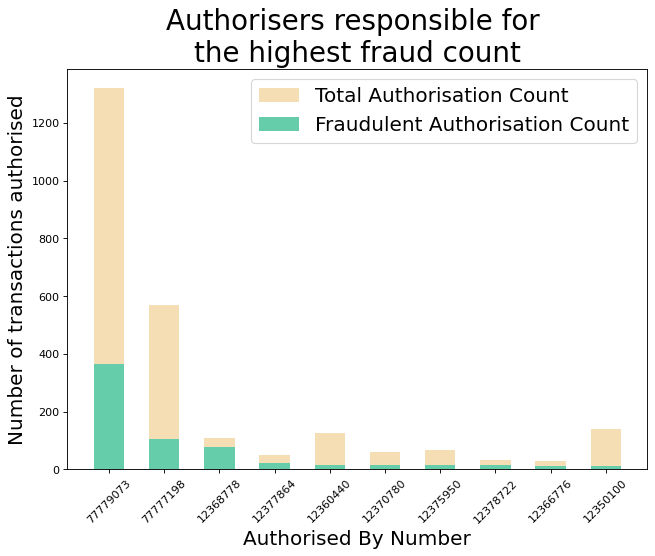

In [ ]:
# Create figure

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)

# Multiple bar chart

abc = ax.bar(x=fraud_vs_total_authorised_df_copy["authorised_by"], height=fraud_vs_total_authorised_df_copy["total_authorised"], width=0.55,align='center', color = 'wheat')
pps = ax.bar(x=fraud_vs_total_authorised_df_copy["authorised_by"], height=fraud_vs_total_authorised_df_copy["fraud_count"], width=0.55,  align='center', color = 'mediumaquamarine')


# for i in range(10):
#   height = pps[i].get_height()
#   green_height = abc[i].get_height()
#   ax.text(x=pps[i].get_x() + pps[i].get_width() / 2, y=height+20,
#       s="{}%". format(round(fraud_vs_total_authorised_df_copy.iloc[i, "fraud_count"]/fraud_vs_total_authorised_df_copy.iloc[i, "total_authorised"]*100),2),
#       ha='center',
#       fontsize = 15)







  # ax.text(x=p.get_x() + p.get_width() / 2, y=height+20,
  #     s="{}%".format(height),
  #     ha='center',
  #     fontsize = 15)





# Define x-ticks

plt.xticks(rotation=45)
# Layout and Display

plt.tight_layout()
plt.title("Authorisers responsible for \nthe highest fraud count",  fontsize=25)
plt.legend(['Total Authorisation Count', 'Fraudulent Authorisation Count'], fontsize=18 )

plt.xlabel("Authorised By Number",  fontsize=18)
plt.ylabel("Number of transactions authorised",  fontsize=18)
plt.show()

In [ ]:
query_1_6 = "select t1.employee_master, sum(t2.total_expense) as total_fraud from nn_employee as t1, Transaction_Data_csv as t2 where t2.expense_date > t1.final_date AND t1.final_date <= '2021-12-31' and t1.final_date >= '2021-07-01' and t1.employee_master = t2.employee_number group by t1.employee_master;"

In [ ]:
employee_fraud_after_quit = read_query(cn, query_1_6)
employee_fraud_after_quit

,employee_master,total_fraud
0,0038261,794.33000
1,0226741,13167.97000
2,0036145,72115.04000
3,0061235,74488.12000
4,0202683,14621.91000
5,0229870,9613.34000
6,0039798,29048.31000
7,0059418,4033.10000
8,0036901,31199.67000
9,0231304,54746.53000


In [ ]:
employee_fraud_after_quit = employee_fraud_after_quit.sort_values(by = "total_fraud", ascending = False)

In [ ]:
employee_fraud_after_quit

,employee_master,total_fraud
3,0061235,74488.12000
2,0036145,72115.04000
9,0231304,54746.53000
8,0036901,31199.67000
6,0039798,29048.31000
14,0054160,21413.43000
4,0202683,14621.91000
1,0226741,13167.97000
20,0038819,10242.52000
19,0037105,10177.08000


In [ ]:
print("Total Amount Lost:")
print(employee_fraud_after_quit["total_fraud"].sum())

Total Amount Lost:
358596.62000


In [ ]:
employee_fraud_after_quit = employee_fraud_after_quit[:10]

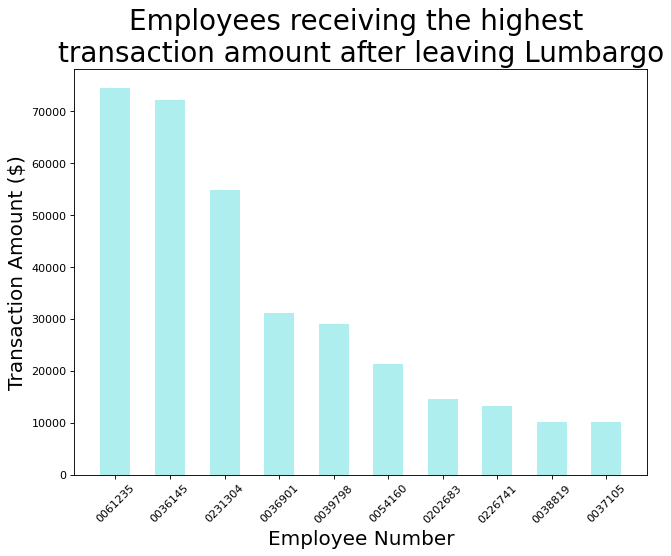

In [ ]:
# Create figure

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)

# Multiple bar chart

ax.bar(x=employee_fraud_after_quit["employee_master"], height=employee_fraud_after_quit["total_fraud"], width=0.55,align='center', color = 'paleturquoise')

# Define x-ticks

plt.xticks(rotation=45)
# Layout and Display

plt.tight_layout()
plt.title("Employees receiving the highest \ntransaction amount after leaving Lumbargo",  fontsize=25)

plt.xlabel("Employee Number",  fontsize=18)
plt.ylabel("Transaction Amount ($)",  fontsize=18)
plt.show()

## END OF PAYROLL DATA FINDINGS